In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import openpyxl

## Transaction Dataset

In [43]:
#Import Dataframe
df_tran = pd.read_excel("99Bikers.xlsx", sheet_name="Transactions")

In [44]:
#Explore Dataframe: Variables and dtypes
df_tran.dtypes

transaction_id                      int64
product_id                          int64
customer_id                         int64
transaction_date           datetime64[ns]
online_order                      float64
order_status                       object
brand                              object
product_line                       object
product_class                      object
product_size                       object
list_price                        float64
standard_cost                     float64
product_first_sold_date           float64
dtype: object

In [45]:
# Changing 'online_order' to boolean
df_tran["online_order"] = df_tran["online_order"].astype("bool")

# Dropping irrelevant columns
df_tran = df_tran.drop(['product_first_sold_date'], axis='columns')

In [46]:
# None of the variables have a missing value percentage of 20% or higher, so I'm going to impute some data :P
((df_tran.isnull().sum())/df_tran.shape[0])*100

# Missing values:
# online_order, brand, product_line, product_class, product_size, standard_cost, product_first_sold_date

transaction_id      0.000
product_id          0.000
customer_id         0.000
transaction_date    0.000
online_order        0.000
order_status        0.000
brand               0.985
product_line        0.985
product_class       0.985
product_size        0.985
list_price          0.000
standard_cost       0.985
dtype: float64

In [47]:
na_val = ['online_order', 'brand', 'product_line', 'product_class', 'product_size', 'standard_cost']
df_tran[na_val]

,online_order,brand,product_line,product_class,product_size,standard_cost
0,False,Solex,Standard,medium,medium,53.62
1,True,Trek Bicycles,Standard,medium,large,388.92
2,False,OHM Cycles,Standard,low,medium,248.82
3,False,Norco Bicycles,Standard,medium,medium,381.10
4,True,Giant Bicycles,Standard,medium,large,709.48
...,...,...,...,...,...,...
19995,True,OHM Cycles,Standard,high,medium,1203.40
19996,True,Solex,Road,medium,medium,312.74
19997,True,OHM Cycles,Standard,medium,medium,44.71
19998,False,OHM Cycles,Standard,high,medium,136.73


In [48]:
# We will fill 'brand' with 'Solex', the mode
df_tran['brand'].value_counts()
df_tran['brand'] = df_tran['brand'].fillna('Solex')

# Replacing half of missing values with True and the other half with False since the split is pretty even
df_tran['online_order'].value_counts()
nans = df_tran['online_order'].isna()
length = sum(nans)
replacement = random.choices([False, True], weights=[.5, .5], k=length)
df_tran.loc[nans,'online_order'] = replacement

# Replacing null values in 'product' columns with their mode
product_info = ['product_line', 'product_class', 'product_size']
mode = df_tran[product_info].mode()
df_tran[product_info] = df_tran[product_info].fillna(mode.iloc[0])

# Replacing null values in 'standard_cost' with mean
df_tran['standard_cost'] = df_tran['standard_cost'].fillna(df_tran['standard_cost'].mean())

# No more null values :3
df_tran.isnull().sum()

transaction_id      0
product_id          0
customer_id         0
transaction_date    0
online_order        0
order_status        0
brand               0
product_line        0
product_class       0
product_size        0
list_price          0
standard_cost       0
dtype: int64

## Customer Demographics Dataframe

In [49]:
#Import Dataframe
df_cd = pd.read_excel("99Bikers.xlsx", sheet_name="CustomerDemographic")

In [50]:
#Explore Dataframe: variables and dtypes
df_cd.dtypes

customer_id                              int64
first_name                              object
last_name                               object
gender                                  object
past_3_years_bike_related_purchases      int64
DOB                                     object
job_title                               object
job_industry_category                   object
wealth_segment                          object
deceased_indicator                      object
default                                 object
owns_car                                object
tenure                                 float64
dtype: object

In [51]:
# Dropping these random variables that have zero explanation or aren't relevant
df_cd = df_cd.drop(['first_name', 'last_name', 'job_title', 'wealth_segment',
                    'deceased_indicator', 'default'], axis='columns')

# Cleaning up gender column
mapping2 = {'F': 'Female', 'M': 'Male', 'U': 'Other', 'Femal': 'Female', '':'Other'}
df_cd['gender'] = df_cd['gender'].map(mapping2)
df_cd['gender'] = df_cd['gender'].fillna('Other')

# None of the variables have a missing value percentage of 20% or higher, so I'm going to impute some data :P
((df_cd.isnull().sum())/df_cd.shape[0])*100

customer_id                             0.000
gender                                  0.000
past_3_years_bike_related_purchases     0.000
DOB                                     2.175
job_industry_category                  16.400
owns_car                                0.000
tenure                                  2.175
dtype: float64

In [52]:
# Filling 'job_industry_category' missing values with 'Other'
df_cd['job_industry_category'] = df_cd['job_industry_category'].fillna('Other')

# Since DOB can't be imputed, we'll drop rows with missing DOB
df_cd = df_cd.dropna(subset='DOB')

# No more missing values >:)
((df_cd.isnull().sum())/df_cd.shape[0])*100

customer_id                            0.0
gender                                 0.0
past_3_years_bike_related_purchases    0.0
DOB                                    0.0
job_industry_category                  0.0
owns_car                               0.0
tenure                                 0.0
dtype: float64

In [53]:
# I want to get people's ages as of December 31, 2017 (since we will be analyzing data from that year)
# This way I can group customer's by age later

# The format for DOB is YYYY-MM-DD
from  datetime import date, datetime

curr_date = '2017-12-31'
date_format = '%Y-%m-%d'
date_obj = datetime.strptime(curr_date, date_format)

df_cd["DOB"] = pd.to_datetime(df_cd["DOB"])
df_cd["AgeDays"] = date_obj - df_cd["DOB"]
df_cd["age"] = df_cd["AgeDays"].dt.days.astype("int16") // 365
df_cd = df_cd.drop(['AgeDays'], axis='columns')

In [54]:
# We have values below 0 which make no sense, removing any age less than 0
# Dropping ages less than 0
df_cd = df_cd.drop(df_cd[df_cd['age'] < 0].index)

## Data Exploration

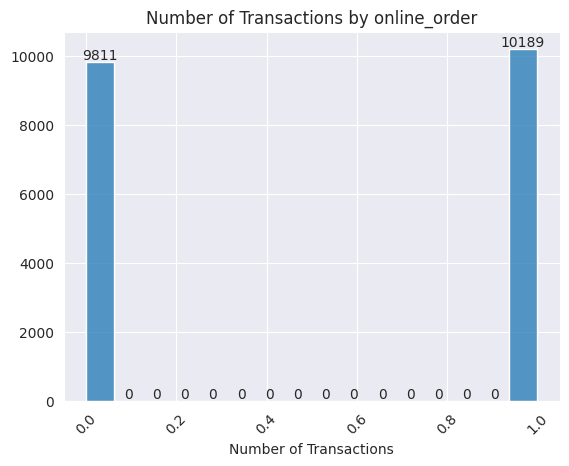

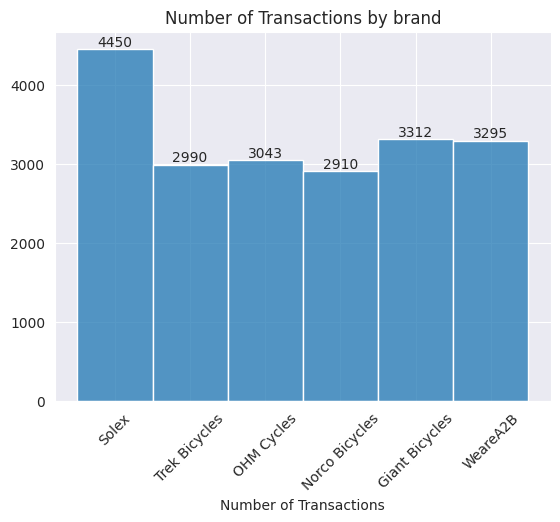

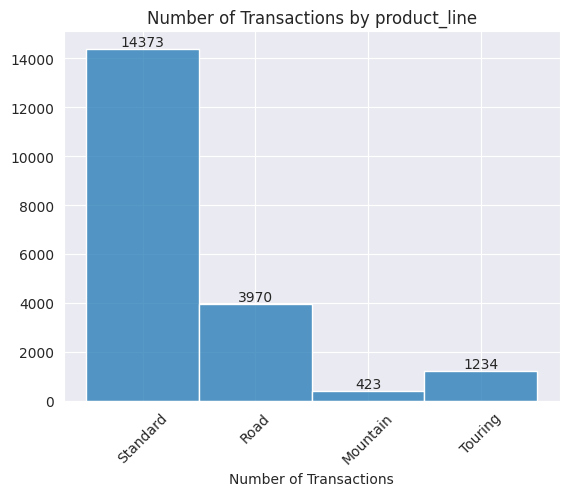

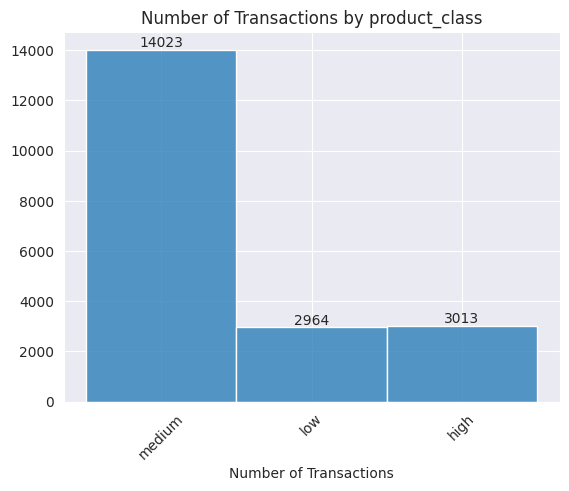

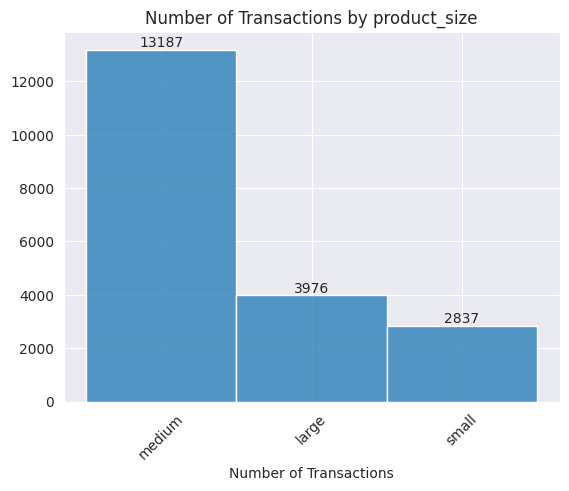

In [55]:
features = ["online_order", "brand", "product_line", "product_class", "product_size"]

for idx, feature in enumerate(features, 1):
  ax = sns.histplot(data=df_tran, x=feature)
  ax.bar_label(ax.containers[0])
  plt.title(f"Number of Transactions by {feature}")
  plt.xlabel("Number of Transactions")
  plt.xticks(rotation=45)
  plt.ylabel("")
  plt.show()

Number of Customers:  3494


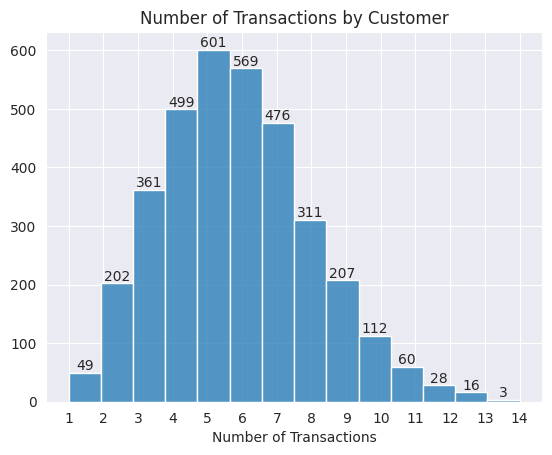

In [56]:
#Group Transactions by CustomerID
df_tran_group = pd.DataFrame(df_tran.groupby("customer_id")["customer_id"].size().reset_index(name='counts'))
print("Number of Customers: ", df_tran_group["customer_id"].nunique())
#Plot Histogram for number of order for each customer
sns.set_style("darkgrid")
ax = sns.histplot(data=df_tran_group, x="counts", bins=14)
ax.bar_label(ax.containers[0])
plt.title("Number of Transactions by Customer")
plt.xlabel("Number of Transactions")
plt.xticks(df_tran_group["counts"].unique())
plt.ylabel("")
plt.show()